# Example 2: Fingerprint atomic crystal structures and learning their energy 

#### Huan Tran

The main objective of this example is to get a small dataset of atomic crystal structures and their energy, fingerprint them, and develop some ML models using different learning algorithms. 

### 1. Download data
The dataset contains 329 equilibrium structures of 13 different stoichiometries of Mg and Si, whose energy was computed using DFT. This dataset was reported in [T. D. Huan, <em>Pressure-stabilized binary compounds of magnesium and silicon</em>, Phys. Rev. Materials <strong>2</strong>, 023803 (2018)]. It will be obtained from www.matsml.org. More information on the avaiable datasets can be found at www.matsml.org as well.

In [1]:
from matsml.data import Datasets
import os
import pandas as pd

# Load data
ds_name='crystals_MgSi'
data=Datasets(ds_name=ds_name)
data.load_dataset()

# have a look at the content
print (pd.read_csv(os.path.join(os.getcwd(),str(ds_name),'summary.csv')))

  matsML, version 1.0.0
  *****
  Load requested dataset(s)
    Data saved in crystals_MgSi
                file_name     target
0    mg2si_struct_01.vasp  -8.924797
1    mg2si_struct_02.vasp -34.985707
2    mg2si_struct_03.vasp -17.246812
3    mg2si_struct_04.vasp -34.062642
4    mg2si_struct_05.vasp -34.035175
..                    ...        ...
324   mgsi_struct_30.vasp -40.698471
325   mgsi_struct_31.vasp -40.598719
326   mgsi_struct_32.vasp -40.499177
327   mgsi_struct_33.vasp  -6.706034
328   mgsi_struct_34.vasp -40.362384

[329 rows x 2 columns]


### 2. Fingerprint the obtained data
Two kinds of crystal fingerprints will be used in this example

1. Ewald sum matrix [Fe. Faber, A. Lindmaa, O. Anatole von Lilienfeld, and R. Armiento. <em>Crystal structure representations for machine learning models of formation energies</em> Int. J. Quantum Chem., 115, 1094 (2015)] is an analogy to the Coulomb matrix for molecules, and its size also depends on the number of atoms of the structure. We used a similar projection on a set of Gaussian. Keyword for this fingerprint is __pesm_crystals__.

2. Smooth Overlap of Atomic Positions (SOAP) [S. De, A. P. Bartók, G. Csányi, and M. Ceriotti, <em>Comparing molecules and solids across structural and alchemical space</em>, Phys. Chem. Chem. Phys. __18__, 13754 (2016)] is a more sophisticated fingerprint. Different from the Ewald sum matrix which is defined for the whole system, SOAP is defined for each atom. Herein, for simplicity, the atomic fingerprints are added up to make the fingerprint for the whole system. In some ML potential, the SOAP fingerprints are used in a different way, involving the "atomic energy". The keyword for SOAP in matsML is __soap_crystals__.

In [2]:
import pandas as pd
from matsml.fingerprint import Fingerprint

summary=os.path.join(os.getcwd(),'crystals_MgSi/summary.csv')
data_loc=os.path.join(os.getcwd(),'crystals_MgSi')
n_atoms_max=28                         # Max number of atoms in all the structures
fp_dim=20                              # intended fingerprint dimensionality
verbosity=0                            # verbosity, 0 or 1
species=['Mg','Si']

# Edwald sum matrix
data_params_pesm={'summary':summary,'data_loc':data_loc,'fp_file':'fp_crystals_MgSi_pesm.csv',
    'fp_type':'pesm_crystals','fp_dim':fp_dim,'verbosity':verbosity,'n_atoms_max':n_atoms_max,
    'species':species}

fp_pesm=Fingerprint(data_params_pesm)
fp_pesm.get_fingerprint()

# SOAP
data_params_soap={'summary':summary,'data_loc':data_loc,'fp_file':'fp_crystals_MgSi_soap.csv',
    'fp_type':'soap_crystals','fp_dim':fp_dim,'verbosity':verbosity,'n_atoms_max':n_atoms_max,
    'species':species}
fp_pesm=Fingerprint(data_params_soap)
fp_pesm.get_fingerprint()

  Atomic structure fingerprinting
    summary                      /home/huan/work/matsml_examples/ex3_crystals/crystals_MgSi/summary.csv
    data_loc                     /home/huan/work/matsml_examples/ex3_crystals/crystals_MgSi
    species                      ['Mg', 'Si']
    fp_type                      pesm_crystals
    fp_file                      fp_crystals_MgSi_pesm.csv
    fp_dim                       20
    n_atoms_max                  28
    verbosity                    0
  Read input
    num_structs                  329
  Computing Ewald sum Matrix
    [==                                                ] 3%

/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


    [==================================================] 100%
  Projecting Ewald sum matrix to create fingerprints
    [==================================================] 100%
  Done fingerprinting, results saved in fp_crystals_MgSi_pesm.csv
  Atomic structure fingerprinting
    summary                      /home/huan/work/matsml_examples/ex3_crystals/crystals_MgSi/summary.csv
    data_loc                     /home/huan/work/matsml_examples/ex3_crystals/crystals_MgSi
    species                      ['Mg', 'Si']
    fp_type                      soap_crystals
    fp_file                      fp_crystals_MgSi_soap.csv
    fp_dim                       20
    n_atoms_max                  28
    verbosity                    0
  Read input
    num_structs                  329
  Computing SOAP fingerprint with DScribe
    [==================================================] 100%
  Done fingerprinting, results saved in fp_crystals_MgSi_soap.csv


__The fingerprinting step maybe a bit slow for a tutorial because we need to set n_atoms_max=28, which results in quite large Ewald sum matricies. A version of fingerprinted data can also be obtained in case you want to skip this step.__

In [3]:
from matsml.data import Datasets
import os
import pandas as pd

# Load data
data=Datasets(ds_soap='fp_crystals_MgSi_soap', ds_pesm='fp_crystals_MgSi_pesm')
data.load_dataset()

print (os.path.isfile('fp_crystals_MgSi_soap.csv.gz'))
print (os.path.isfile('fp_crystals_MgSi_pesm.csv.gz'))

  Load requested dataset(s)
    Data saved in fp_crystals_MgSi_soap.csv.gz
    Data saved in fp_crystals_MgSi_pesm.csv.gz
True
True


### 3. Train several ML models with two fingerprint files just created

In [4]:
# data parameters for learning

id_col=['id']                              # this is id column in the fingerprint data
y_cols=['target']                          # this is y columns 
comment_cols=[]                            # other columns that are not id, not x, nor y columns
n_trains=0.9                               # 90% for training, 15% for validating
sampling='random'                          # way of train/test spliting. Random and more
x_scaling='minmax'                         
y_scaling='minmax'

data_params_pesm={'data_file':'fp_crystals_MgSi_pesm.csv','id_col':id_col,'y_cols':y_cols,
    'comment_cols':comment_cols,'y_scaling':y_scaling,'x_scaling':x_scaling,'sampling':sampling, 
    'n_trains':n_trains}

data_params_soap={'data_file':'fp_crystals_MgSi_soap.csv','id_col':id_col,'y_cols':y_cols,
    'comment_cols':comment_cols,'y_scaling':y_scaling,'x_scaling':x_scaling,'sampling':sampling, 
    'n_trains':n_trains}

#### 3a. Fully-connected NeuralNet

 
  Learning fingerprinted/featured data
    algorithm                    fully connected NeuralNet w/ TensorFlow
    layers                       [4, 4]
    activ_funct                  selu
    epochs                       2000
    optimizer                    nadam
    nfold_cv                     5
  Checking parameters
    all passed                   True
  Read data
    data file                    fp_crystals_MgSi_pesm.csv
    data size                    329
    training size                296 (90.0 %)
    test size                    33 (10.0 %)
    x dimensionality             19
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
    xscaler saved in             xscaler.pkl
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 FCNN
  Training model w/ cross validation
    cv,rmse_train,rmse_test,rmse_opt: 0 0.059275 0.072458 0.072458
    cv,rmse_tra

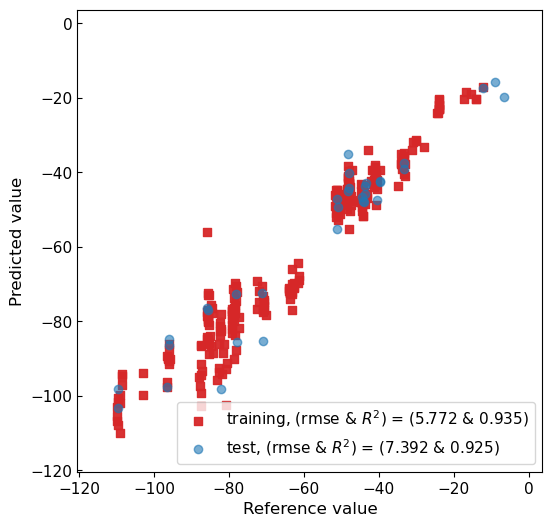

 
  Learning fingerprinted/featured data
    algorithm                    fully connected NeuralNet w/ TensorFlow
    layers                       [4, 4]
    activ_funct                  selu
    epochs                       2000
    optimizer                    nadam
    nfold_cv                     5
  Checking parameters
    all passed                   True
  Read data
    data file                    fp_crystals_MgSi_soap.csv
    data size                    329
    training size                296 (90.0 %)
    test size                    33 (10.0 %)
    x dimensionality             275
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
    xscaler saved in             xscaler.pkl
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 FCNN
  Training model w/ cross validation
    cv,rmse_train,rmse_test,rmse_opt: 0 0.008504 0.009348 0.009348
    cv,rmse_tr

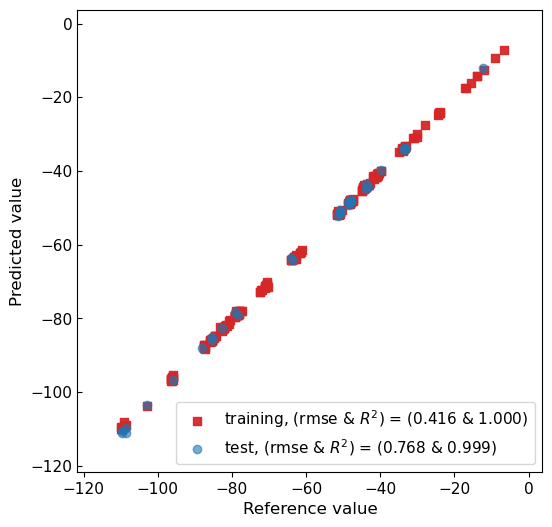

In [5]:
from matsml.models import FCNN

# Model parameters
layers=[4,4]                 # list of nodes in hidden layers
epochs=2000                  # Epochs
nfold_cv=5                   # Number of folds for cross validation
use_bias=True                # Use bias term or not
model_file='model_nn.pkl'    # Name of the model file to be created
verbosity=0                  # Verbosity, 0 or 1
batch_size=32                # Default = 32
loss='mse'                   
activ_funct='selu'           # Options: "tanh", "relu", and more
optimizer='nadam'            # options: "Nadam", "Adam", and more

model_params={'layers':layers,'activ_funct':activ_funct,'epochs':epochs,'nfold_cv':nfold_cv,
    'optimizer':optimizer,'use_bias':use_bias,'model_file':model_file,'loss':loss,
    'batch_size':batch_size,'verbosity':verbosity,'rmse_cv':False}

# PESM
model=FCNN(data_params=data_params_pesm,model_params=model_params)
model.train()
model.plot(pdf_output=False)

# SOAP
model=FCNN(data_params=data_params_soap,model_params=model_params)
model.train()
model.plot(pdf_output=False)

#### 3b. KRR

 
  Learning fingerprinted/featured data
    algorithm                    kernel ridge regression w/ scikit-learn
    kernel                       rbf
    nfold_cv                     5
    alpha                        [-2, 5]
    gamma                        [-2, 5]
    number of alpha/gamma grids  10
  Checking parameters
    all passed                   True
  Read data
    data file                    fp_crystals_MgSi_pesm.csv
    data size                    329
    training size                296 (90.0 %)
    test size                    33 (10.0 %)
    x dimensionality             19
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
    xscaler saved in             xscaler.pkl
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 KRR
  Training model w/ cross validation
  KRR model trained, now make predictions & invert scaling
    unscaling y: minmax


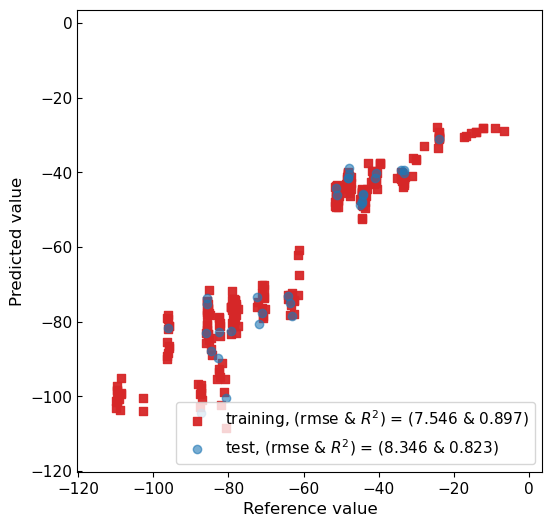

 
  Learning fingerprinted/featured data
    algorithm                    kernel ridge regression w/ scikit-learn
    kernel                       rbf
    nfold_cv                     5
    alpha                        [-2, 5]
    gamma                        [-2, 5]
    number of alpha/gamma grids  10
  Checking parameters
    all passed                   True
  Read data
    data file                    fp_crystals_MgSi_soap.csv
    data size                    329
    training size                296 (90.0 %)
    test size                    33 (10.0 %)
    x dimensionality             275
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
    xscaler saved in             xscaler.pkl
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 KRR
  Training model w/ cross validation
  KRR model trained, now make predictions & invert scaling
    unscaling y: minmax

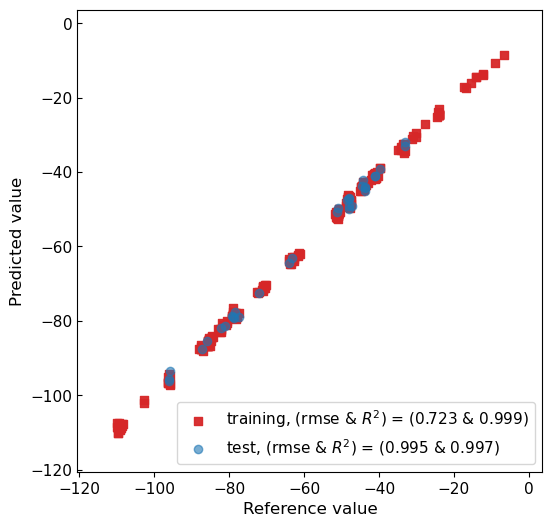

In [6]:
from matsml.models import KRR

# Model parameters
nfold_cv = 5                     # Number of folds for cross validation
model_file = 'model_krr.pkl'     # Name of the model file to be created
alpha = [-2,5]
gamma = [-2,5]
n_grids = 10
kernel = 'rbf'

model_params={'kernel':kernel,'nfold_cv':nfold_cv,'model_file':model_file,'alpha':alpha,
    'gamma':gamma,'n_grids':n_grids}

#PCM
model = KRR(data_params=data_params_pesm,model_params=model_params)
model.train()
model.plot(pdf_output=False)

#SOAP
model = KRR(data_params=data_params_soap,model_params=model_params)
model.train()
model.plot(pdf_output=False)

#### 3c. GPR

 
  Learning fingerprinted/featured data
    algorithm                    gaussian process regression w/ scikit-learn
    nfold_cv                     5
    optimizer                    fmin_l_bfgs_b
    n_restarts_optimizer         200
    rmse_cv                      False
  Checking parameters
    all passed                   True
  Read data
    data file                    fp_crystals_MgSi_pesm.csv
    data size                    329
    training size                296 (90.0 %)
    test size                    33 (10.0 %)
    x dimensionality             19
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
    xscaler saved in             xscaler.pkl
  Scaling y                      minmax
  Prepare train/test sets        random
  Training model w/ cross validation
    cv,rmse_train,rmse_test,rmse_opt: 0 0.056704 0.064423 0.064423
    cv,rmse_train,rmse_test,rmse_opt: 1 0.055103 0.068148 0.064423
    cv,rmse_tr

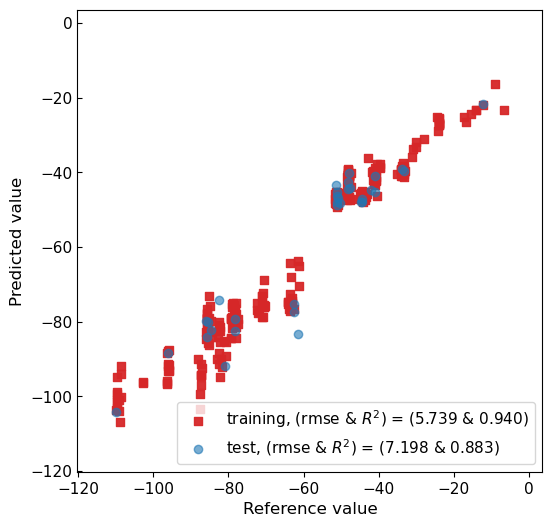

 
  Learning fingerprinted/featured data
    algorithm                    gaussian process regression w/ scikit-learn
    nfold_cv                     5
    optimizer                    fmin_l_bfgs_b
    n_restarts_optimizer         200
    rmse_cv                      False
  Checking parameters
    all passed                   True
  Read data
    data file                    fp_crystals_MgSi_soap.csv
    data size                    329
    training size                296 (90.0 %)
    test size                    33 (10.0 %)
    x dimensionality             275
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
    xscaler saved in             xscaler.pkl
  Scaling y                      minmax
  Prepare train/test sets        random
  Training model w/ cross validation
    cv,rmse_train,rmse_test,rmse_opt: 0 0.003832 0.005269 0.005269
    cv,rmse_train,rmse_test,rmse_opt: 1 0.003830 0.006250 0.005269
    cv,rmse_t

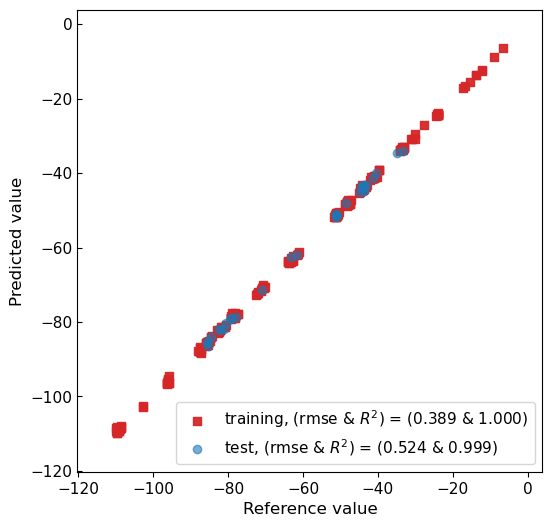

In [7]:
from matsml.models import GPR

# Model parameters
nfold_cv=5                     # Number of folds for cross validation
model_file='model_gpr.pkl'     # Name of the model file to be created
verbosity=0
rmse_cv=False
n_restarts_optimizer=200

model_params={'nfold_cv':nfold_cv,'n_restarts_optimizer':n_restarts_optimizer,'model_file':model_file,
    'verbosity':verbosity,'rmse_cv':rmse_cv}

#PCM
model=GPR(data_params=data_params_pesm,model_params=model_params)
model.train()
model.plot(pdf_output=False)

#SOAP
model=GPR(data_params=data_params_soap,model_params=model_params)
model.train()
model.plot(pdf_output=False)